# Unsupervised Learning Trading Strategy
* Download & load the stock price for SP500
* Calculate diferent indicators
* Aggregate on monthly level & filter top 150 most liquid stocks
* Calculate Monthly Returns for different time-zones
* Downloade Fama-French Factors & calculate rolling factor beats
* For each month fit a K-Means Clustering Algorithm to group similar assets based ontheir features
* For each month select assets based on the cluster and form a portafolio based on Eficcient Frontier mas sharp ratio optimization
* Visualize Portafolio returns & compare it to the SP500 returns

## Packages needed:
* Pandas
* Numpy
* Matplotlib
* Statsmodels
* Pandas_datareader
* datetime
* yfinance
* sklearn
* PyPortfolioOpt
* pandas_ta

## 1)Download/Load SP500 stock price data

In [1]:
#libraries
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install Statsmodels
#!pip install pandas_datareader
#!pip install datetime
#!pip install yfinance
#!pip install scikit-learn
#!pip install PyPortfolioOpt
#!pip install pandas_ta

In [2]:
#Importing all the packages
from statsmodels.regression.rolling import RollingOLS
from sklearn.cluster import KMeans
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
#to fix the tickers
import matplotlib.ticker as mtick
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
#pandas_ta used to calculate the indicators of the project
import pandas_ta
import warnings
import certifi
warnings.filterwarnings('ignore')

#Importing the list of companies in the SP500 list
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

#Changing the dot on the symbols to relieve conflict with yfinance
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

#We grab the unique list of symbols
symbols_list= sp500['Symbol'].unique().tolist()

#Limiting the time of date we are going to download
## 1)Set it for todays date
## 2)Set a horizon for the date
end_date= dt.date.today().strftime('%Y-%m-%d')
### Start date of the data will be 8 years ago from the end date
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# We will obtain the data from Yfinance
df = yf.download(tickers = symbols_list,
                 start = start_date,
                 end = end_date).stack()

#Multiple index to set the date and ticker as a index
df.index.names= ['date', 'ticker']

#Changes all the name of the columns into lower case 
df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2015-12-09 A        38.366261   40.980000   41.799999   40.910000   41.250000   
           AAL      41.713928   43.650002   45.189999   43.189999   44.299999   
           AAPL     26.314919   28.905001   29.422501   28.770000   29.410000   
           ABBV     39.659710   56.029999   57.439999   55.720001   56.279999   
           ABT      38.703823   44.959999   45.700001   44.810001   45.389999   
...                       ...         ...         ...         ...         ...   
2023-12-06 YUM     124.809998  124.809998  125.279999  124.019997  125.050003   
           ZBH     116.129997  116.129997  116.589996  115.290001  116.360001   
           ZBRA    234.130005  234.130005  238.720001  233.839996  237.669998   
           ZION     37.150002   37.150002   38.689999   37.049999   37.900002   
           ZTS     182.000000  182.000000  183.179993  180.639999  180.750000   

                        volume  
date       ticker               
2015-12-09 A         4133300.0  
           AAL       8001000.0  
           AAPL    185445600.0  
           ABBV      6207900.0  
           ABT       5544400.0  
...                        ...  
2023-12-06 YUM       1596600.0  
           ZBH       1385800.0  
           ZBRA       222300.0  
           ZION      2393500.0  
           ZTS       1552900.0  

[995047 rows x 6 columns]

## 2) Calculation of indicators
This will be done for each stock:
* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Value



In [3]:
#We are going to calculate this indicators using there corresponding formulas according to the literature
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

#We are going to calculate the RSI
df['rsi'] = df.groupby(level =1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, lenght = 20))

#We are going to calculate the Bollinger Bands (we need to deefine which band to use since the method gives 5)
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length= 20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length= 20).iloc[:,1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.bbands(close = np.log1p(x), length= 20).iloc[:,2])

#We are going to calculate the ATR (we use 3 columns as an input so we cant use transform. We need our own custom function)
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14
                       )
    return atr.sub(atr.mean()).div(atr.std())
#We call the function for every ticker
df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

#We also need a function for a MACDE
def compute_macd(close):
    macd = pandas_ta.macd(close= close, length = 20).iloc [:,0]
    return macd.sub(macd.mean()).div(macd.std())#This is to normalize the data to use it for ML
#We call the function we created
df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)
    
#We create the dollar Value coplumn
df['dollar_volume'] = df['adj close']* df['volume']/1e6 #Divided by a million since millions of shares are traded on a day

    
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-12-09 A        38.366261   40.980000   41.799999   40.910000   41.250000   
           AAL      41.713928   43.650002   45.189999   43.189999   44.299999   
           AAPL     26.314919   28.905001   29.422501   28.770000   29.410000   
           ABBV     39.659710   56.029999   57.439999   55.720001   56.279999   
           ABT      38.703823   44.959999   45.700001   44.810001   45.389999   
...                       ...         ...         ...         ...         ...   
2023-12-06 YUM     124.809998  124.809998  125.279999  124.019997  125.050003   
           ZBH     116.129997  116.129997  116.589996  115.290001  116.360001   
           ZBRA    234.130005  234.130005  238.720001  233.839996  237.669998   
           ZION     37.150002   37.150002   38.689999   37.049999   37.900002   
           ZTS     182.000000  182.000000  183.179993  180.639999  180.750000   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-12-09 A         4133300.0         -0.001797        NaN       NaN   
           AAL       8001000.0         -0.000373        NaN       NaN   
           AAPL    185445600.0         -0.004525        NaN       NaN   
           ABBV      6207900.0         -0.046860        NaN       NaN   
           ABT       5544400.0         -0.009616        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-06 YUM       1596600.0          0.000050  48.318678  4.826247   
           ZBH       1385800.0          0.000061  63.690166  4.652566   
           ZBRA       222300.0          0.000126  60.811467  5.301403   
           ZION      2393500.0          0.000784  60.952273  3.498012   
           ZTS       1552900.0          0.000079  63.396440  5.132476   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-12-09 A            NaN       NaN       NaN       NaN     158.579265  
           AAL          NaN       NaN       NaN       NaN     333.753140  
           AAPL         NaN       NaN       NaN       NaN    4879.985854  
           ABBV         NaN       NaN       NaN       NaN     246.203513  
           ABT          NaN       NaN       NaN       NaN     214.589477  
...                     ...       ...       ...       ...            ...  
2023-12-06 YUM     4.846171  4.866095  0.122666  0.228522     199.271642  
           ZBH     4.726115  4.799664 -0.635486  0.908274     160.932950  
           ZBRA    5.412276  5.523149 -0.209994  0.735738      52.047100  
           ZION    3.590174  3.682336  0.122891  0.999954      88.918529  
           ZTS     5.176956  5.221437  0.583967  1.182015     282.627800  

[995047 rows x 14 columns]

## 3) Aggregate on a monthly level & filter top 150 most liquid stocks each month
``To reduce training time and experiment with features and stategies, we convert the business-daily data to month-end frequency``


In [4]:


#create listo of columns to calculate the mean of the month for the limitation discused earlier 
last_cols = [ c for c in df.columns.unique(0) if c not in ['dollar_volume','volume',
                                                           'open','high','low','close']]

#To unstack and calculate the mean of the month for the limitation discused earlier and frame only dollar volume and concatenate
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker')], axis = 1).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-01-31 A           95.369733   35.345047 -0.885838  3.682282  3.532355   
           AAL        475.457985   37.260616  2.058549  3.723517  3.618182   
           AAPL      5981.206641   22.154415 -0.834049  3.215938  3.095448   
           ABBV       460.247943   39.268002  0.210647  3.788067  3.650394   
           ABT        326.006430   32.788799 -0.455306  3.667053  3.508551   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        240.702021  124.809998  0.122666  4.866095  4.826247   
           ZBH        159.168051  116.129997 -0.635486  4.799664  4.652566   
           ZBRA        70.691009  234.130005 -0.209994  5.523149  5.301403   
           ZION       114.056773   37.150002  0.122891  3.682336  3.498012   
           ZTS        266.928350  182.000000  0.583967  5.221437  5.132476   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-01-31 A       3.607319          0.000336 -0.790861  43.584517  
           AAL     3.670850          0.002147 -1.091388  41.769935  
           AAPL    3.155693         -0.001265 -0.698130  42.522094  
           ABBV    3.719230         -0.035988 -0.224538  44.715711  
           ABT     3.587802         -0.004372 -1.395821  33.321045  
...                     ...               ...       ...        ...  
2023-12-31 YUM     4.846171          0.000050  0.228522  48.318678  
           ZBH     4.726115          0.000061  0.908274  63.690166  
           ZBRA    5.412276          0.000126  0.735738  60.811467  
           ZION    3.590174          0.000784  0.999954  60.952273  
           ZTS     5.176956          0.000079  1.182015  63.396440  

[47477 rows x 9 columns]

* **Calculate 5 year rolling average of dollar volume for each stock before filtering**

In [5]:

data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5 * 12, min_periods = 12).mean().stack())

#Calculate dollar volume rank cross sectionally 
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending = False)

#We are going to filter to select the top 150 stocks for month
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-12-31 AAL      45.118099  0.400869  3.899765  3.813338  3.856552   
           AAPL     26.946926 -1.123336  3.364473  3.274855  3.319664   
           ABBV     46.037804 -1.263181  3.863187  3.809937  3.836562   
           ABT      33.897526 -1.186314  3.575095  3.535751  3.555423   
           ACN     105.149284 -0.910921  4.743385  4.641425  4.692405   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    353.459991  0.832225  5.936393  5.824220  5.880307   
           VZ       38.500000 -1.083165  3.691559  3.583942  3.637750   
           WFC      44.500000 -0.950978  3.844756  3.719068  3.781912   
           WMT     154.039993  0.562070  5.138616  5.009676  5.074146   
           XOM      99.110001  0.547476  4.672768  4.617307  4.645037   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-12-31 AAL            -0.000637  1.015414  47.932609  
           AAPL           -0.002296 -0.119565  57.882510  
           ABBV           -0.036939 -0.010107  56.942173  
           ABT            -0.005705 -0.355081  45.978562  
           ACN            -0.004741 -0.357236  40.981539  
...                             ...       ...        ...  
2023-12-31 VRTX            0.000099 -1.085782  46.493036  
           VZ              0.000200  2.194378  74.179259  
           WFC             0.000150  1.229398  67.340751  
           WMT             0.000062 -1.729701  38.222131  
           XOM             0.000255 -1.362500  30.858146  

[12665 rows x 8 columns]

## 4) Calculate Monthly Returns for different time horizons as features
To capture time series dynamics taht reflect, for example, momentum patterns, we compute historical returns using the method ``.pct_change(lag)``, that returns over various monthly periods as identified by lags.

In [6]:

#We will create a function to calculate the monthly returns for each ticker
def calculate_returns(df):
    #We are going to deal with the outlier by clipping them (if they are above the threashold we assign them the threashold of that percentile)
    outlier_cutoff = 0.005
    
    #List of lags we want to calculate
    lags = [1,2,3,6,9,12]
    
    for lag in lags:
        #We will create a column that will be return for the given lag month
        df[f'return_{lag}m']= (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower =x.quantile(outlier_cutoff),
                                                      upper =x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
        #The last part of the code is to deal with the outliers
    return df

#We call teh function we created and drop the values with null
data =data.groupby(level =1, group_keys = False).apply(calculate_returns).dropna()

data


adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-12-31 AAL      50.711876 -0.099734  3.972856  3.884601  3.928729   
           AAPL     40.006577 -0.991298  3.754309  3.703448  3.728878   
           ABBV     73.694954 -0.698427  4.338743  4.289143  4.313943   
           ABT      51.533802 -1.129920  3.978439  3.904342  3.941390   
           ACN     140.201782 -0.914005  4.967737  4.907500  4.937618   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    353.459991  0.832225  5.936393  5.824220  5.880307   
           VZ       38.500000 -1.083165  3.691559  3.583942  3.637750   
           WFC      44.500000 -0.950978  3.844756  3.719068  3.781912   
           WMT     154.039993  0.562070  5.138616  5.009676  5.074146   
           XOM      99.110001  0.547476  4.672768  4.617307  4.645037   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-12-31 AAL            -0.000305  1.247862  60.121431   0.030501   
           AAPL           -0.001526 -0.230111  43.270531  -0.015246   
           ABBV           -0.031544  0.196429  52.021012  -0.002167   
           ABT            -0.004710  0.245903  61.019438   0.012418   
           ACN            -0.003561  0.284567  63.833889   0.034322   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000099 -1.085782  46.493036  -0.003805   
           VZ              0.000200  2.194378  74.179259   0.004435   
           WFC             0.000150  1.229398  67.340751  -0.002018   
           WMT             0.000062 -1.729701  38.222131  -0.010598   
           XOM             0.000255 -1.362500  30.858146  -0.035332   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-12-31 AAL      0.055325   0.031653   0.006292   0.023994    0.009787  
           AAPL     0.002359   0.032902   0.028535   0.019684    0.033479  
           ABBV     0.035171   0.031007   0.051953   0.047851    0.039985  
           ABT      0.025851   0.024323   0.028884   0.030147    0.035524  
           ACN      0.037002   0.045983   0.037860   0.029824    0.024265  
...                      ...        ...        ...        ...         ...  
2023-12-31 VRTX    -0.012016   0.005453   0.000733   0.012857    0.016985  
           VZ       0.046866   0.059452   0.012322   0.005035    0.003989  
           WFC      0.062501   0.031903   0.009785   0.022336    0.008846  
           WMT     -0.029093  -0.012430  -0.002768   0.005690    0.007889  
           XOM     -0.027947  -0.052500  -0.010225  -0.008326   -0.006098  

[10500 rows x 14 columns]

## 5) Download Fama-French Factors and Calculate Rolling Factor Beats
1) We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression.
2) The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portafolios. Hence, it is natural to include past factor exposure as financial features in the models.
3) We can access the historical factor returns using the ``pandas-datareader`` and estimate historical exposure using the ``RollingOLS`` rolling linear regression.

In [7]:
#Webscrapping of this page that has diferenrt indicators and first column since there is in months
factor_data= web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start ='2010')[0].drop('RF', axis=1)
#We drop it since its out of the scope of the project

#We change it into a date format that works for us (fix the index)
factor_data.index = factor_data.index.to_timestamp()

#We are going to set it for the last day of the month & change it from a 0.1 into a 10 meanaing %
factor_data = factor_data.resample('M').last().div(100)

#We will also fix the index name
factor_data.index.name = 'date'

# We will join our last date set with this one to keep this values but with our ticker data 
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169   0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169   0.012418
           ACN     0.0106 -0.0107  0.0006  0.0074  0.0169   0.034322
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[10209 rows x 6 columns]

**We will filter out stocks that have less than 10 months of data**
Since we are going to use rolling  lienar regression of data from 2 years. Stocks with not enough data may broke the function.

In [8]:
#List of months of data for each ticker
observation = factor_data.groupby(level = 1).size()

#Filetring only tickers with more than 10 months of data
valid_stocks = observation[observation >= 10]

#We take out the invalid stock tickers
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-12-31 AAL     0.0106 -0.0107  0.0006  0.0074  0.0169   0.030501
           AAPL    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.015246
           ABBV    0.0106 -0.0107  0.0006  0.0074  0.0169  -0.002167
           ABT     0.0106 -0.0107  0.0006  0.0074  0.0169   0.012418
           ACN     0.0106 -0.0107  0.0006  0.0074  0.0169   0.034322
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[10165 rows x 6 columns]

 *Calculate rolling factor Betas*

In [9]:
betas = (factor_data.groupby(level = 1,
                   group_keys = False).apply(lambda x: RollingOLS(endog=x['return_1m'],
                            exog=sm.add_constant (x.drop('return_1m', axis=1)),
                            window = min(24,x.shape[0]),#To limit the amount of data in the window
                            min_nobs = len(x.columns)+1)
                                             .fit(params_only =True)
                                             .params.drop('const',axis = 1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-12-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-10-31 VRTX    0.516105 -0.609321 -0.241792 -0.129190  0.711607
           VZ      0.351237 -0.546768  0.454522  0.271671 -0.153883
           WFC     1.081142  0.342198  2.046439 -0.410923 -1.505578
           WMT     0.686487 -0.333354 -0.423069 -0.136836  0.516188
           XOM     1.016321 -0.783697  1.607300 -0.640025 -0.142490

[10165 rows x 5 columns]

In [10]:
#We will create a list with the factor columns
factors= ['Mkt-RF','SMB','HML','RMW','CMA']

#We need to move this values a month forward before joining to the data since the october info we will have it in november
data = data.join(betas.groupby('ticker').shift())

#Populate de na values
data.loc[:, factors] = data.groupby('ticker',group_keys= False)[factors].apply(lambda x: x.fillna(x.mean()))

#We Drop adj close column
data = data.drop('adj close', axis = 1)

#We drop the NA data
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10280 entries, (Timestamp('2017-12-31 00:00:00'), 'AAL') to (Timestamp('2023-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10280 non-null  float64
 1   bb_high           10280 non-null  float64
 2   bb_low            10280 non-null  float64
 3   bb_mid            10280 non-null  float64
 4   garman_klass_vol  10280 non-null  float64
 5   macd              10280 non-null  float64
 6   rsi               10280 non-null  float64
 7   return_1m         10280 non-null  float64
 8   return_2m         10280 non-null  float64
 9   return_3m         10280 non-null  float64
 10  return_6m         10280 non-null  float64
 11  return_9m         10280 non-null  float64
 12  return_12m        10280 non-null  float64
 13  Mkt-RF            10280 non-null  float64
 14  SMB               10280 non-null  float64
 15  HML        

``Here we decide which ML and aproach to use``

## 6) For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.
* For visualization purpose of this tutorial we will initially relay on the **K-Means** initialization.
* Then we will pre-define our centroids for each cluster.

### We need to give the initial centroids

In [11]:

target_rsi_values = [30,45,55,70]

#18 because its the number of columns
initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:,6] = target_rsi_values 

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [12]:
from sklearn.cluster import KMeans

#We will build a function to create the clusters
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          random_state=0,
                          init =initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-12-31 AAL    -0.099734  3.972856  3.884601  3.928729         -0.000305   
           AAPL   -0.991298  3.754309  3.703448  3.728878         -0.001526   
           ABBV   -0.698427  4.338743  4.289143  4.313943         -0.031544   
           ABT    -1.129920  3.978439  3.904342  3.941390         -0.004710   
           ACN    -0.914005  4.967737  4.907500  4.937618         -0.003561   
...                     ...       ...       ...       ...               ...   
2023-12-31 VRTX    0.832225  5.936393  5.824220  5.880307          0.000099   
           VZ     -1.083165  3.691559  3.583942  3.637750          0.000200   
           WFC    -0.950978  3.844756  3.719068  3.781912          0.000150   
           WMT     0.562070  5.138616  5.009676  5.074146          0.000062   
           XOM     0.547476  4.672768  4.617307  4.645037          0.000255   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-12-31 AAL     1.247862  60.121431   0.030501   0.055325   0.031653   
           AAPL   -0.230111  43.270531  -0.015246   0.002359   0.032902   
           ABBV    0.196429  52.021012  -0.002167   0.035171   0.031007   
           ABT     0.245903  61.019438   0.012418   0.025851   0.024323   
           ACN     0.284567  63.833889   0.034322   0.037002   0.045983   
...                     ...        ...        ...        ...        ...   
2023-12-31 VRTX   -1.085782  46.493036  -0.003805  -0.012016   0.005453   
           VZ      2.194378  74.179259   0.004435   0.046866   0.059452   
           WFC     1.229398  67.340751  -0.002018   0.062501   0.031903   
           WMT    -1.729701  38.222131  -0.010598  -0.029093  -0.012430   
           XOM    -1.362500  30.858146  -0.035332  -0.027947  -0.052500   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-12-31 AAL      0.006292   0.023994    0.009787  1.251265  1.351819   
           AAPL     0.028535   0.019684    0.033479  1.298775 -0.301221   
           ABBV     0.051953   0.047851    0.039985  0.480675  0.427407   
           ABT      0.028884   0.030147    0.035524  0.822189 -0.179076   
           ACN      0.037860   0.029824    0.024265  1.209881 -0.166043   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.000733   0.012857    0.016985  0.535288  0.067356   
           VZ       0.012322   0.005035    0.003989  0.497034 -0.355518   
           WFC      0.009785   0.022336    0.008846  1.082646 -0.107321   
           WMT     -0.002768   0.005690    0.007889  0.614307 -0.453123   
           XOM     -0.010225  -0.008326   -0.006098  1.147034  0.300794   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-12-31 AAL     0.570729  0.376818  0.635504        2  
           AAPL   -0.613676  0.609493  0.539030        0  
           ABBV   -0.065071  0.300869  0.214956        1  
           ABT    -0.522082  0.273503  0.982443        2  
           ACN    -0.314856  0.278195  0.176415        2  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.947330  0.042396  0.857345        1  
           VZ      0.061594  0.296890  0.522609        3  
           WFC     1.398679 -0.735551 -0.552929        3  
           WMT    -0.310267  0.332418  0.716913        1  
           XOM     0.627119 -0.480445  0.697184        0  

[10280 rows x 19 columns]

### We will build a function to visualize this clusters

In [13]:
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    plt.scatter(cluster_0.iloc[:,0],cluster_0.iloc[:,6],color = 'red',label='Cluster 0')
    plt.scatter(cluster_1.iloc[:,0],cluster_1.iloc[:,6],color = 'green',label='Cluster 1')
    plt.scatter(cluster_2.iloc[:,0],cluster_2.iloc[:,6],color = 'blue',label='Cluster 2')
    plt.scatter(cluster_3.iloc[:,0],cluster_3.iloc[:,6], color = 'black',label = 'Cluster 3')
    
    plt.legend()
    plt.show()
    return

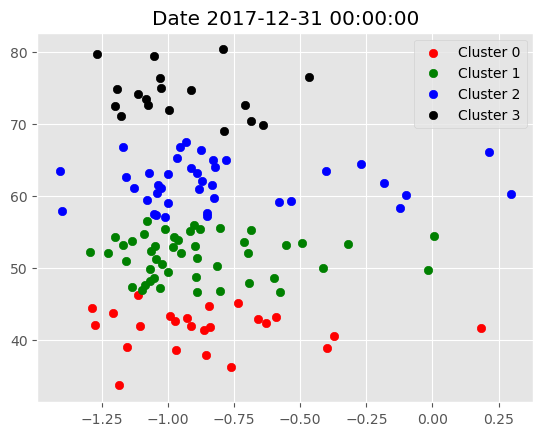

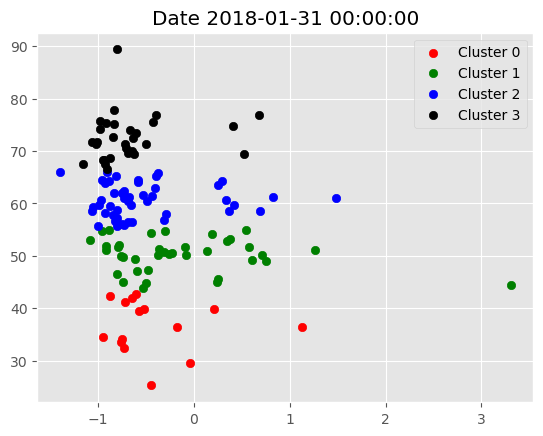

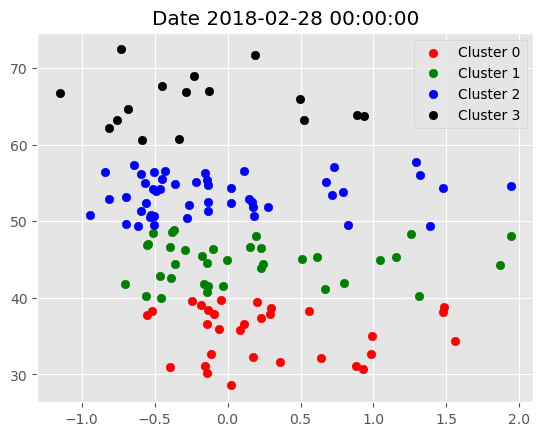

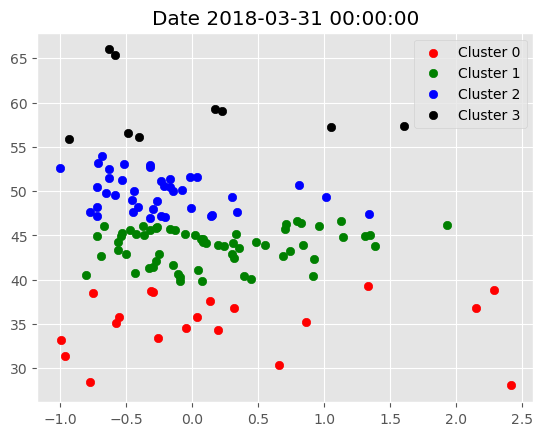

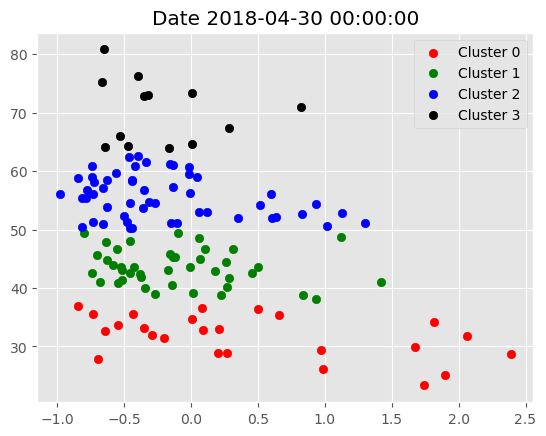

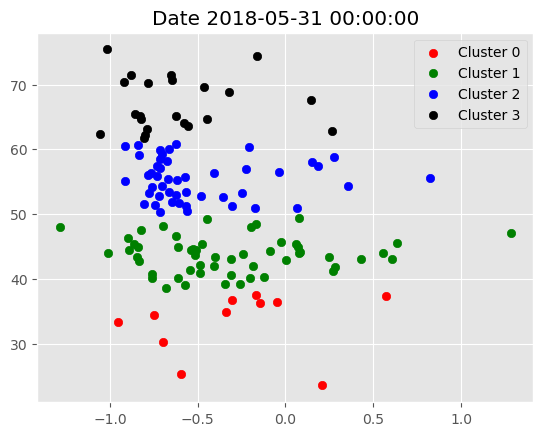

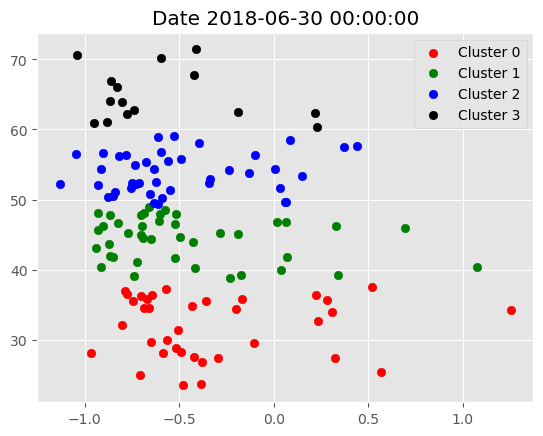

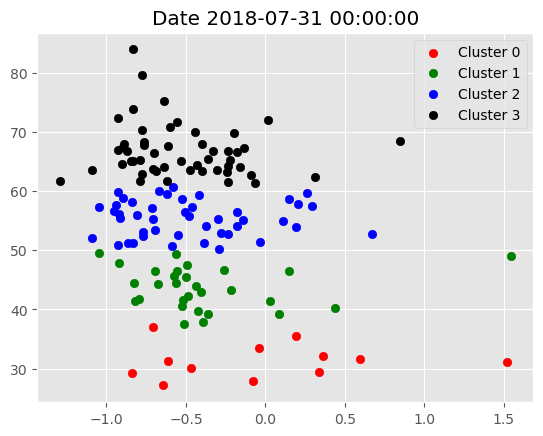

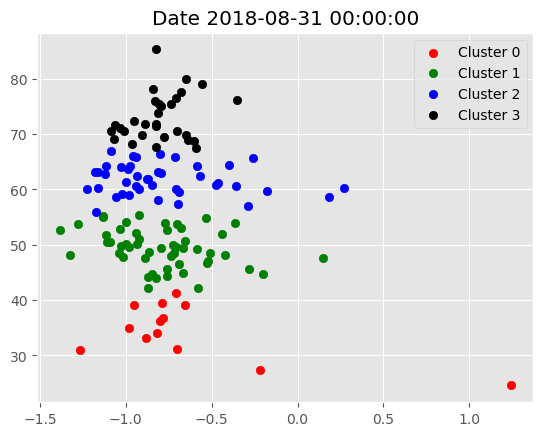

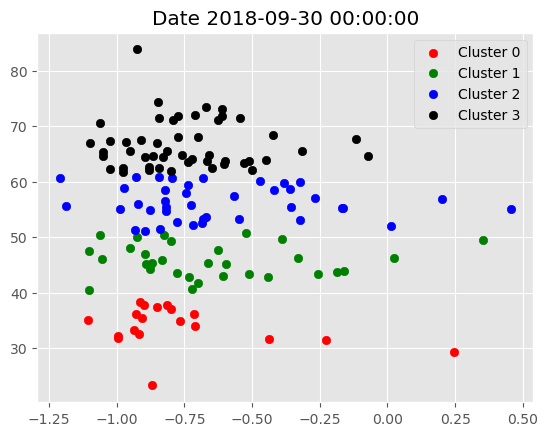

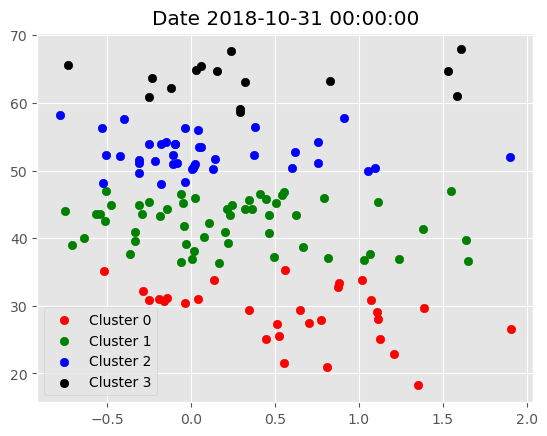

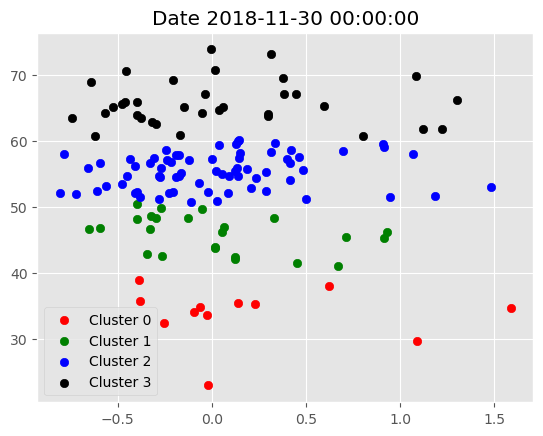

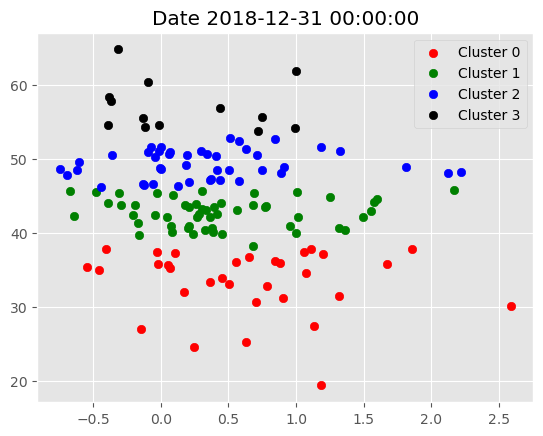

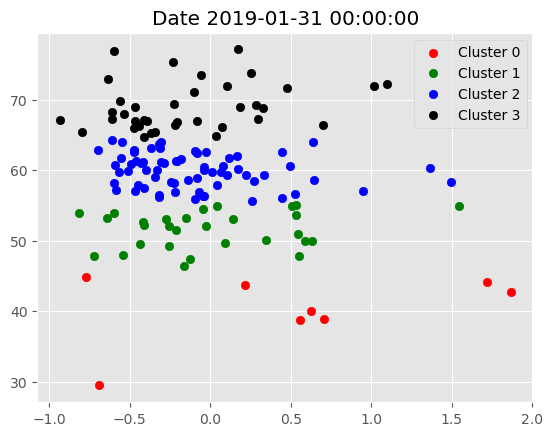

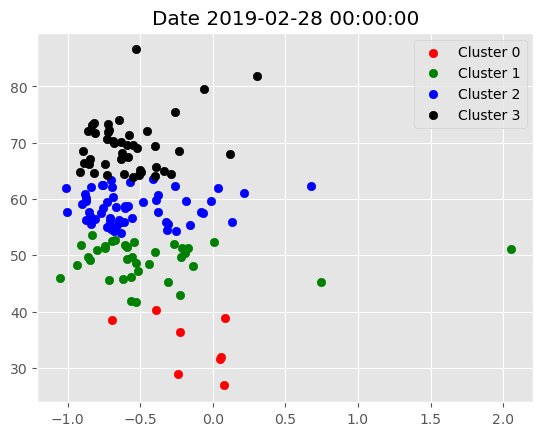

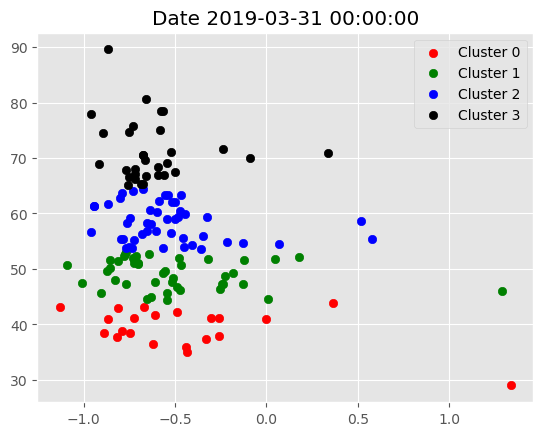

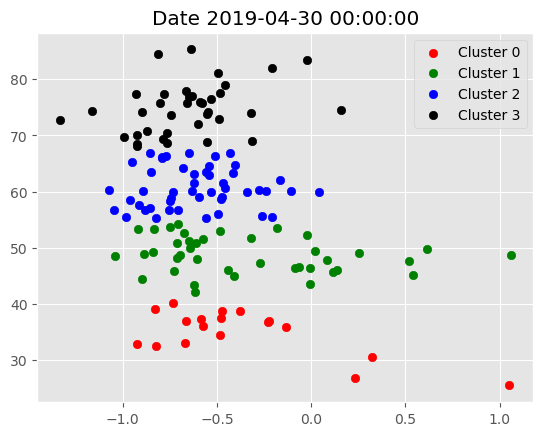

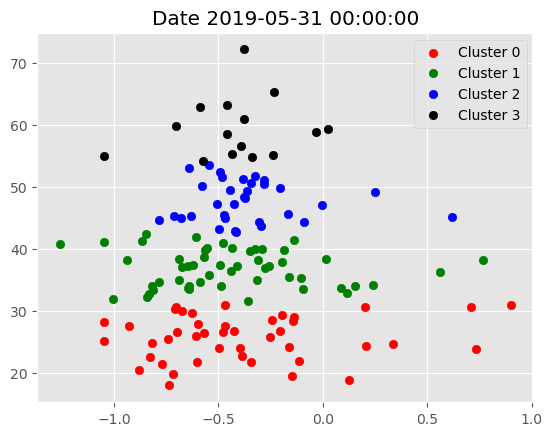

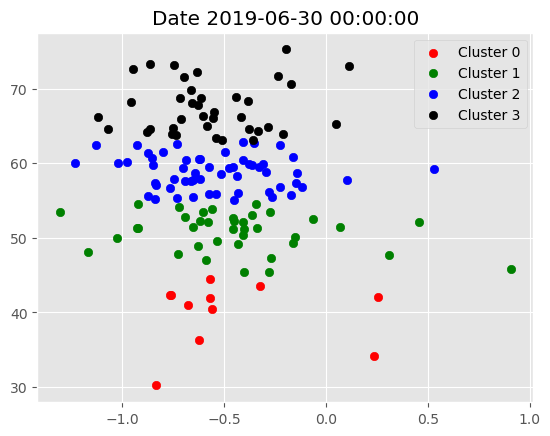

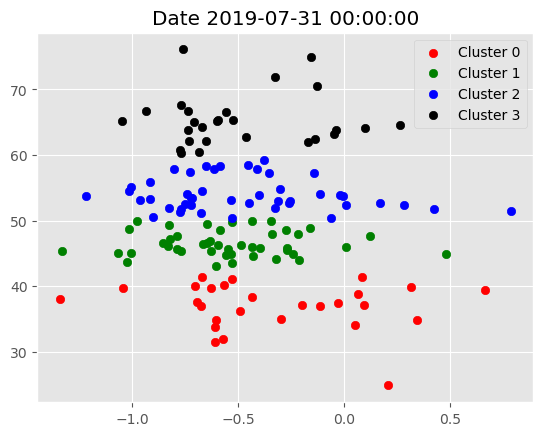

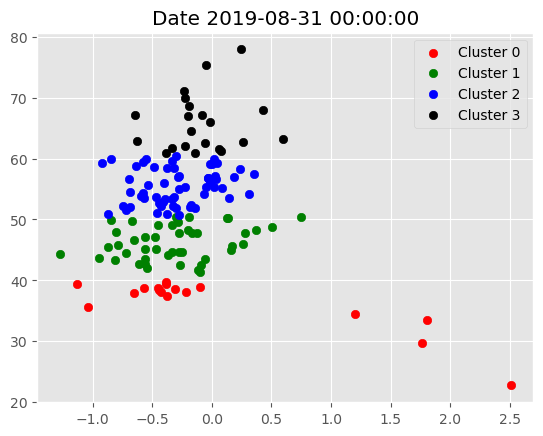

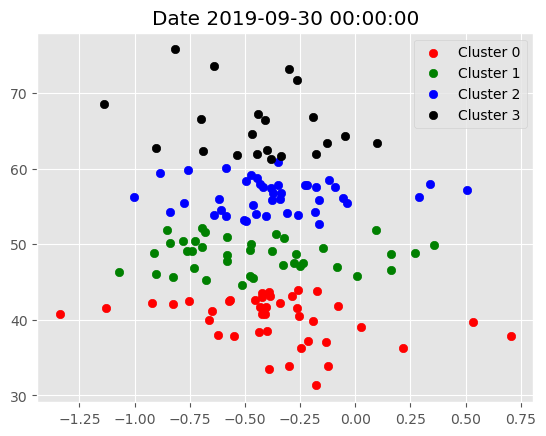

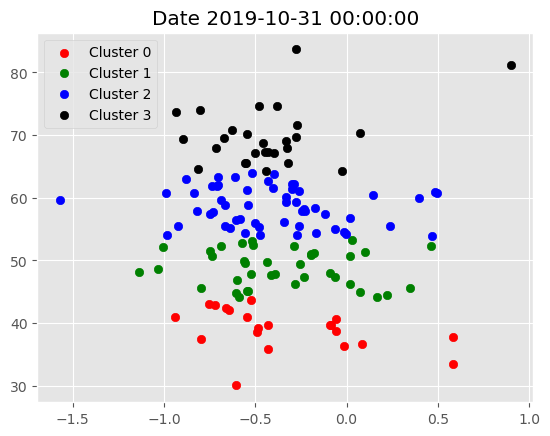

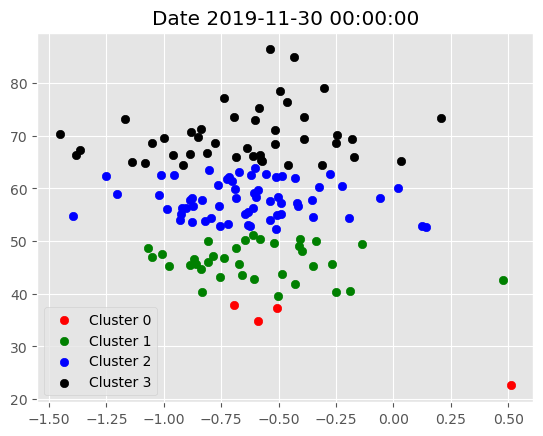

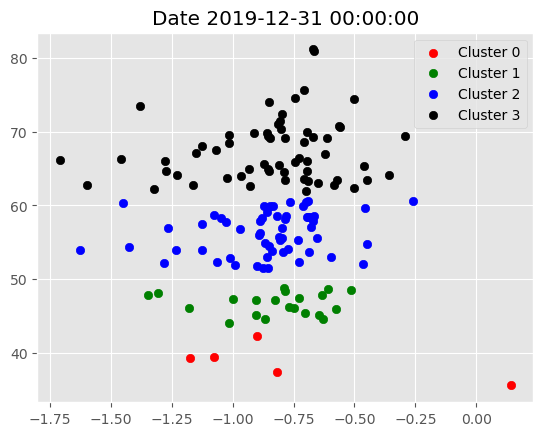

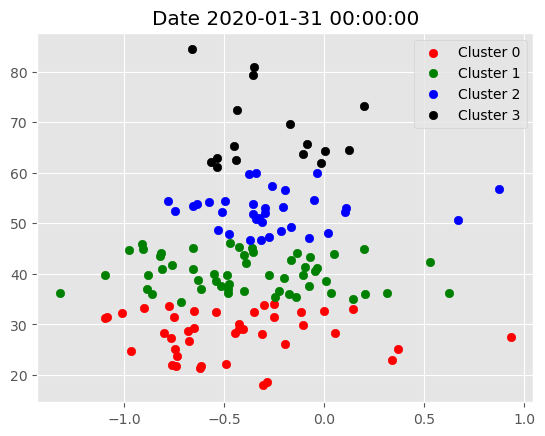

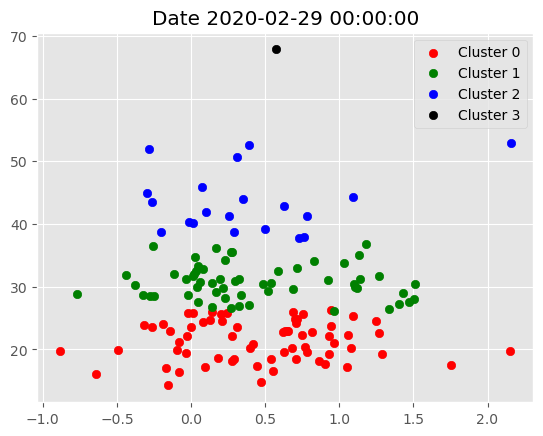

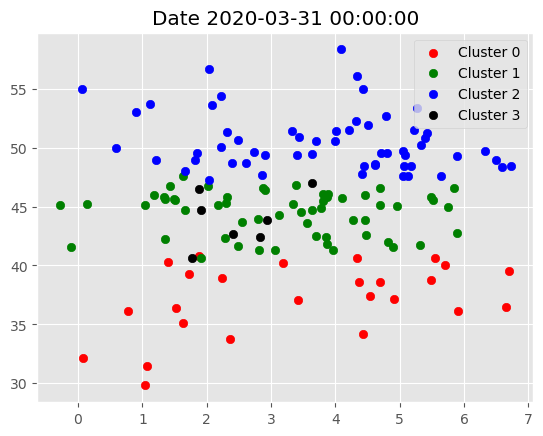

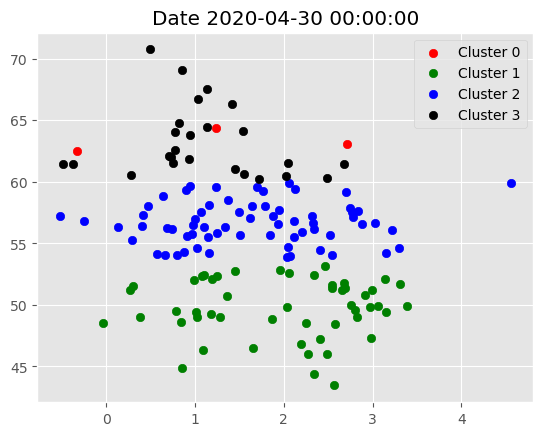

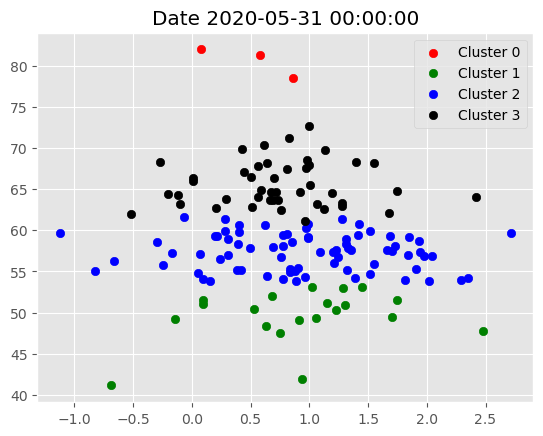

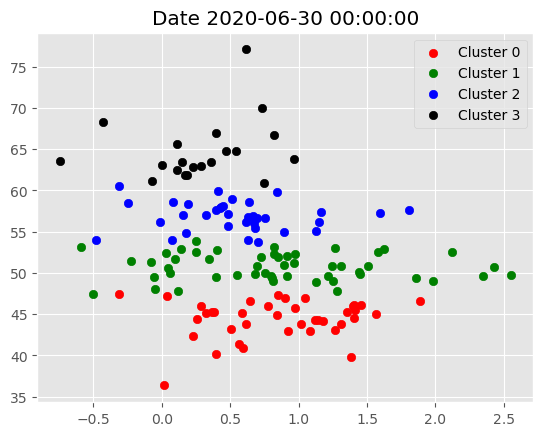

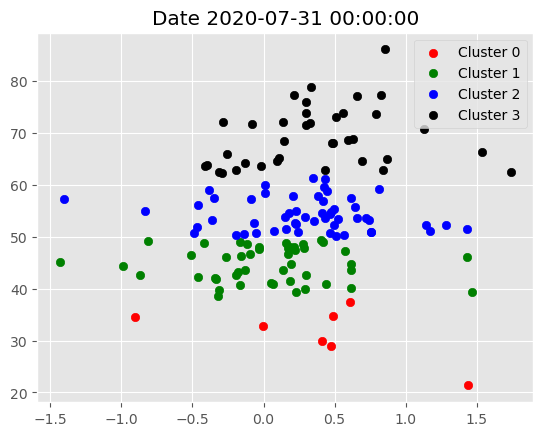

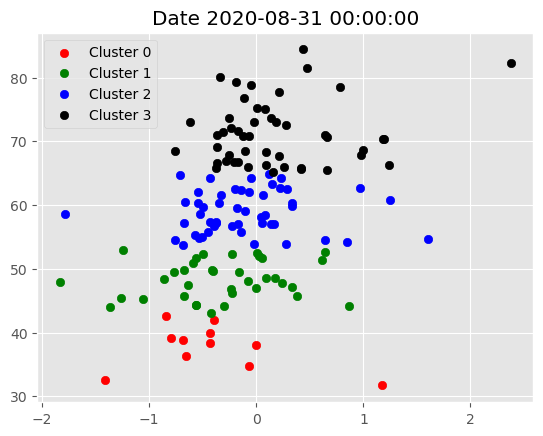

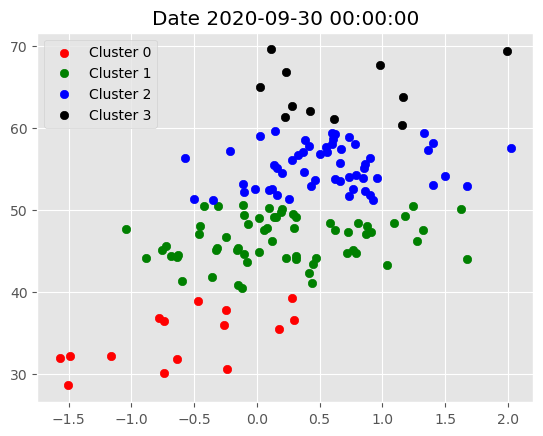

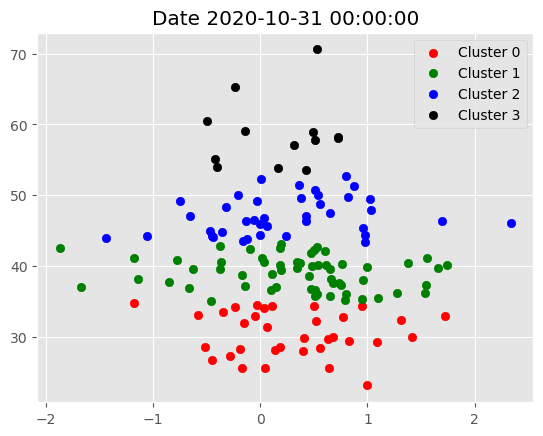

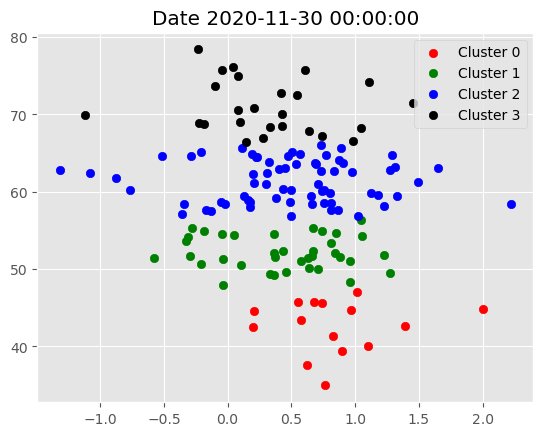

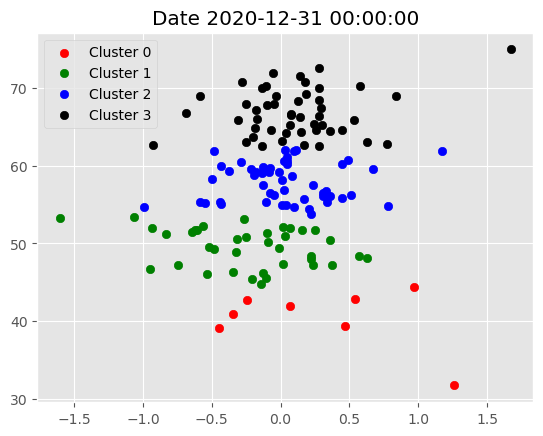

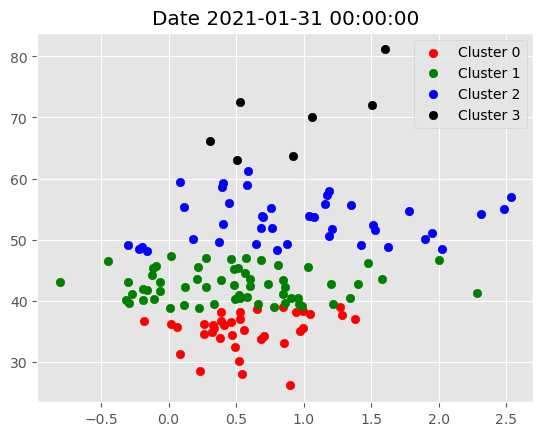

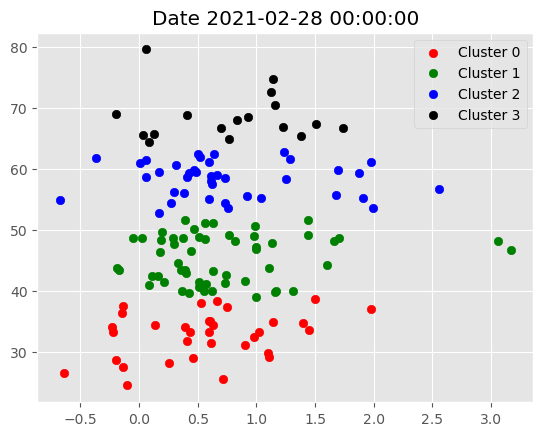

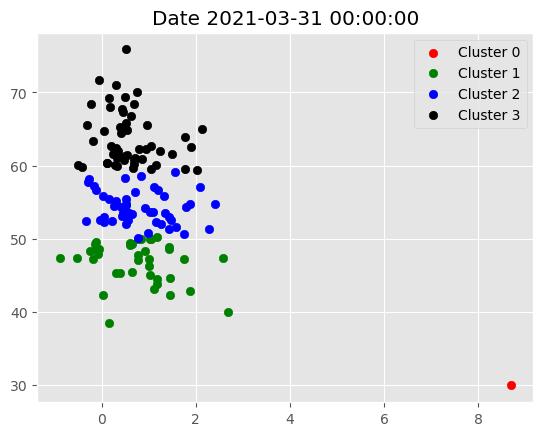

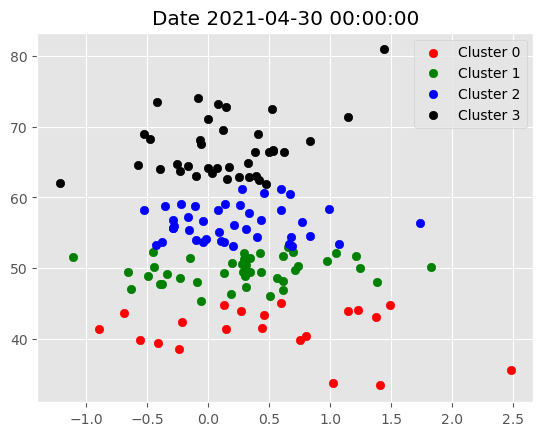

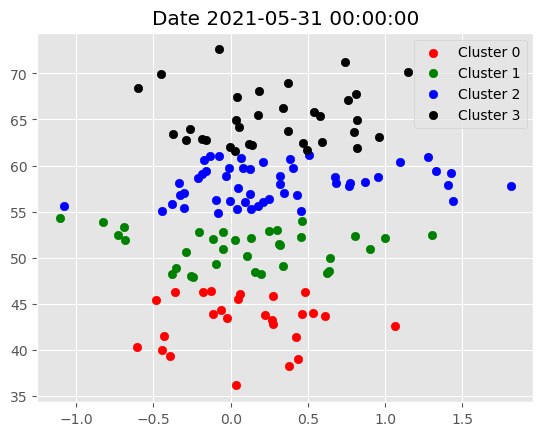

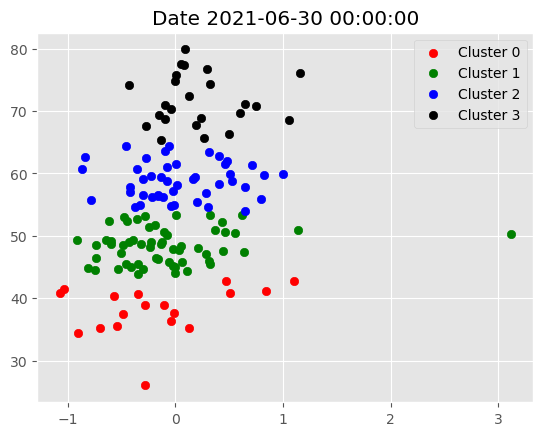

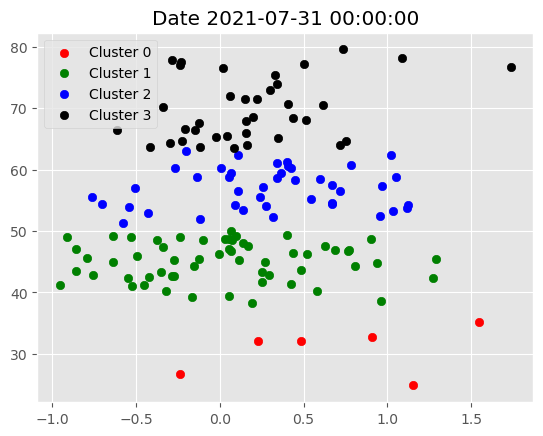

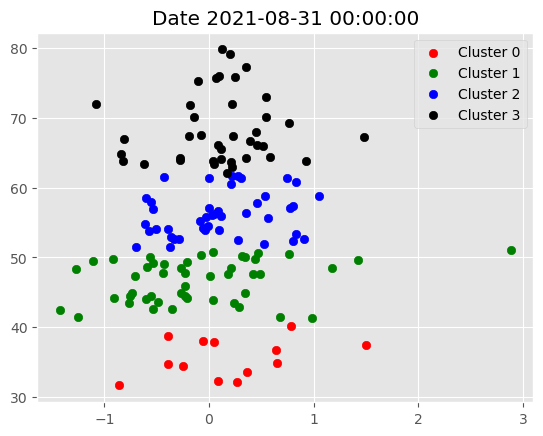

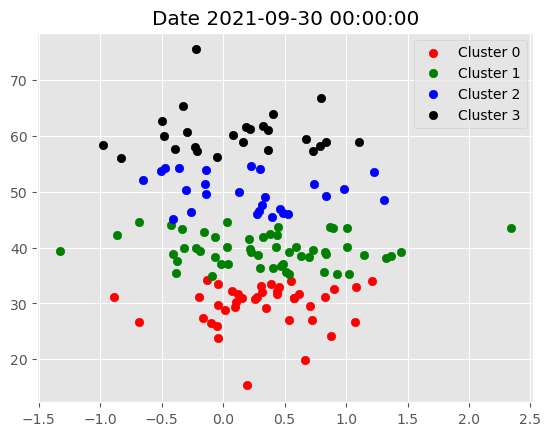

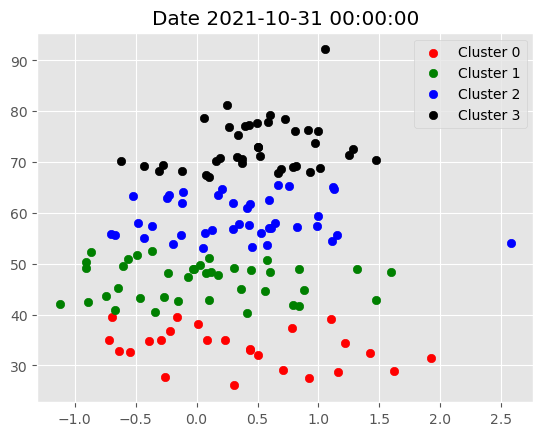

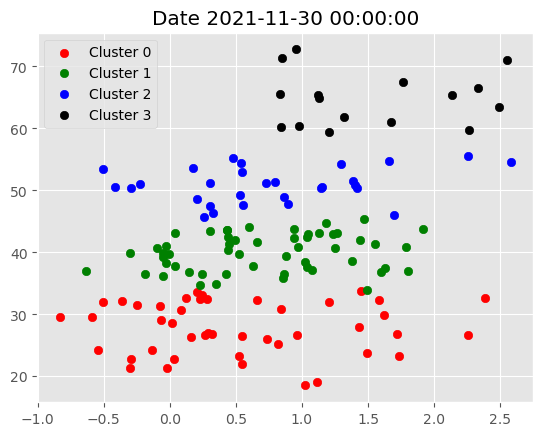

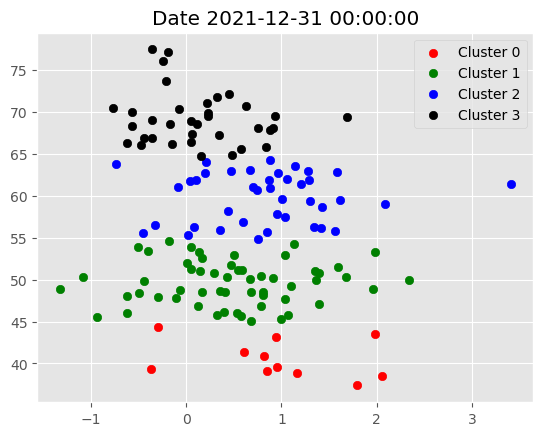

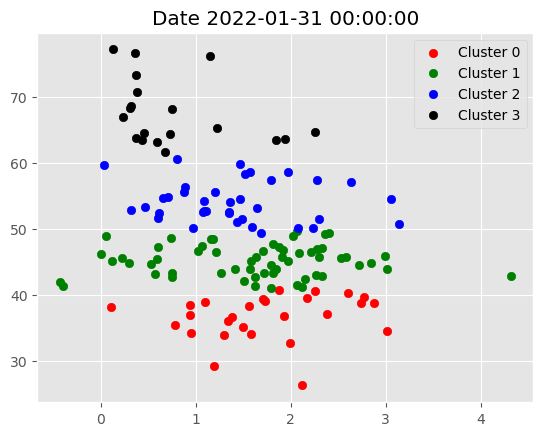

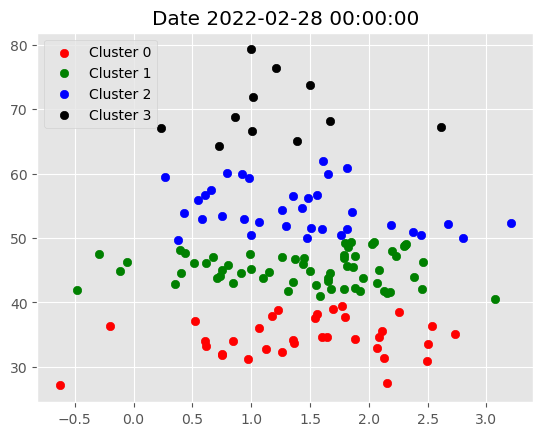

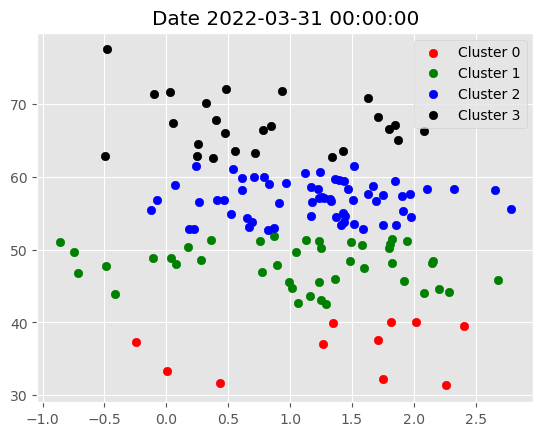

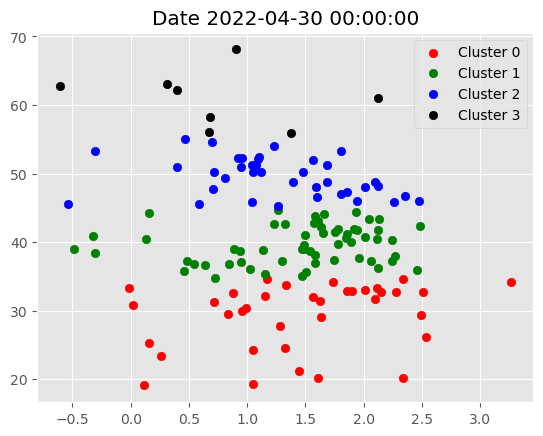

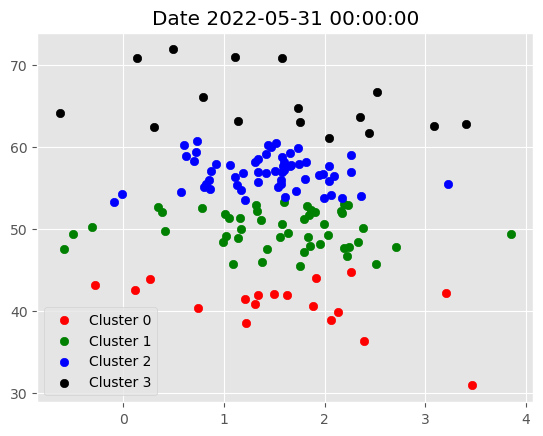

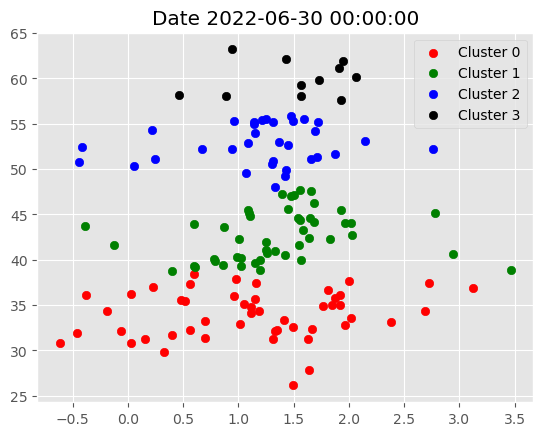

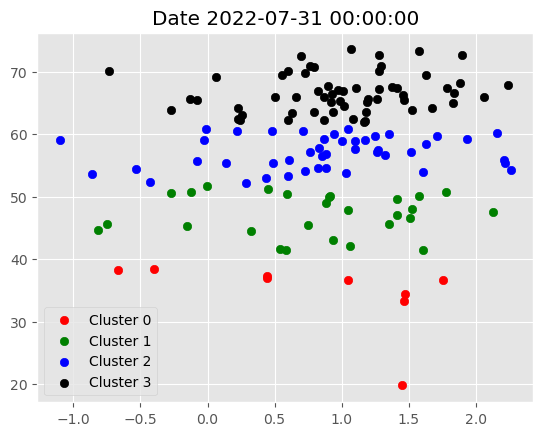

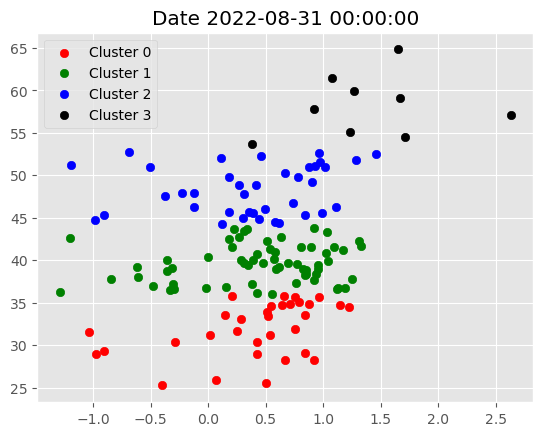

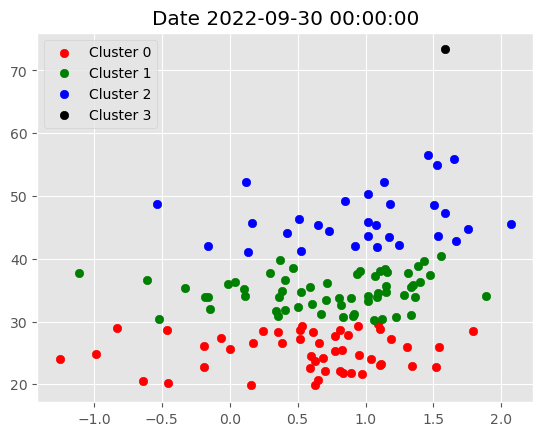

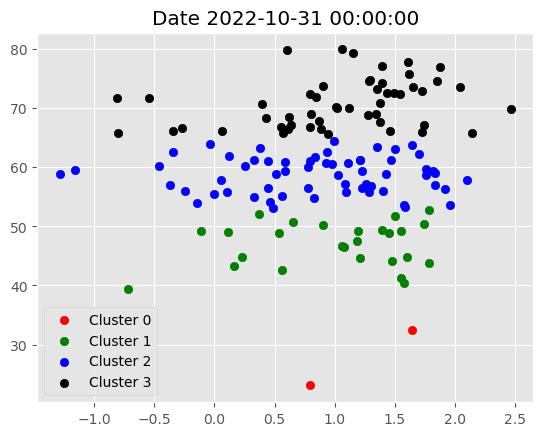

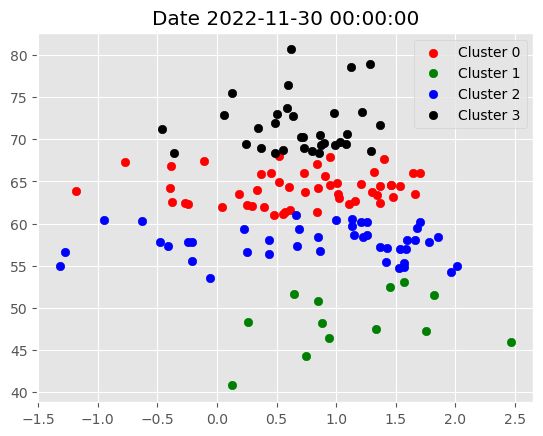

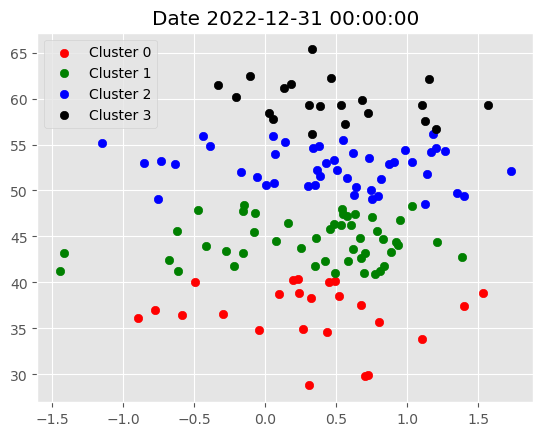

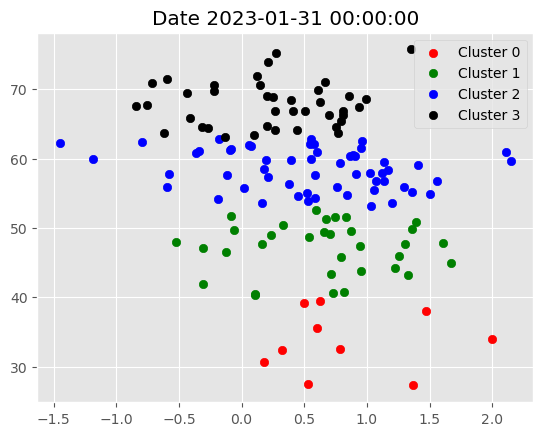

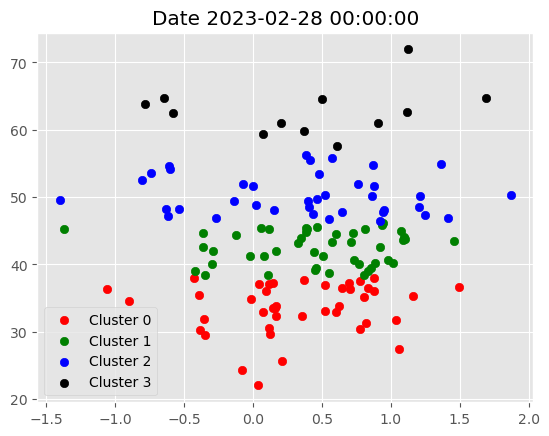

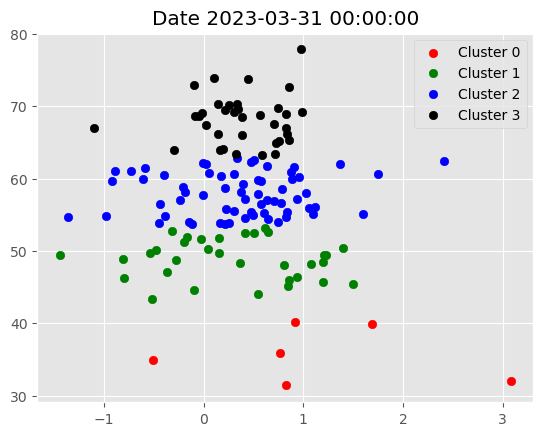

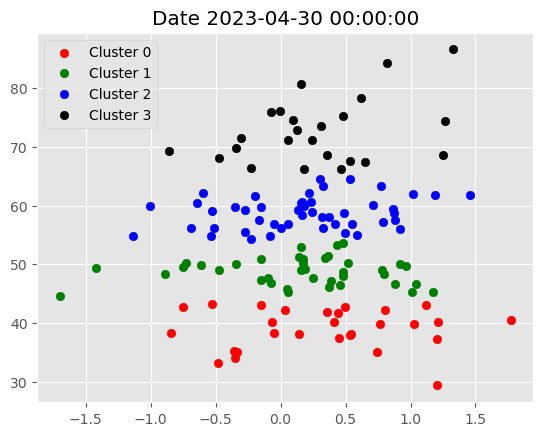

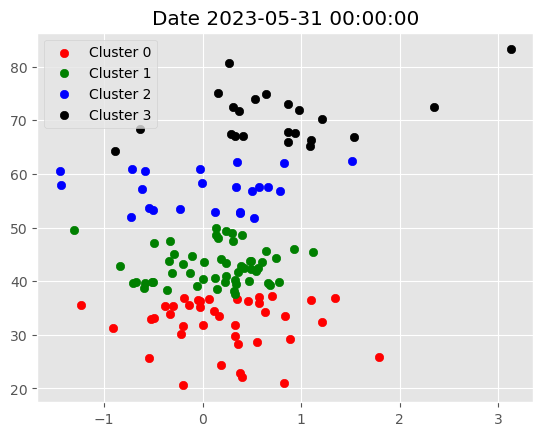

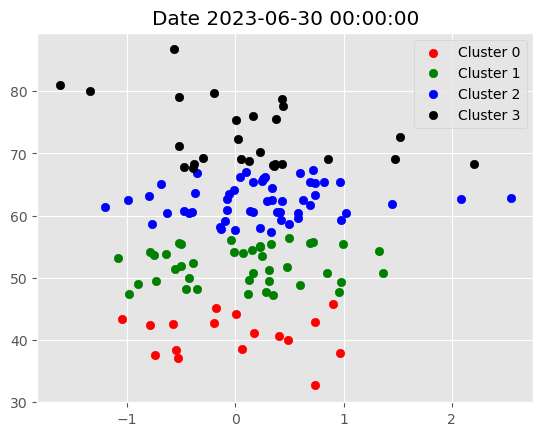

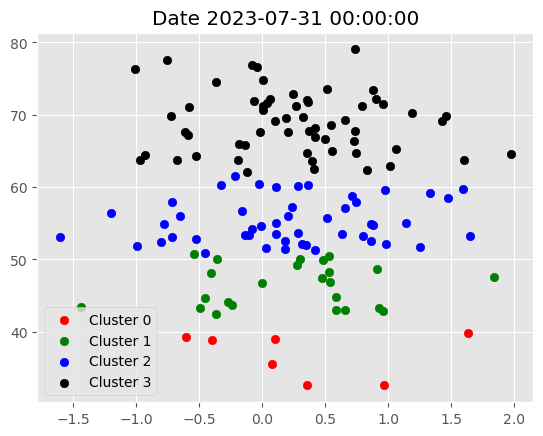

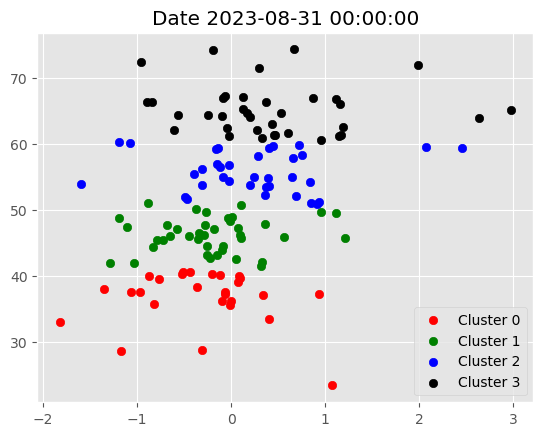

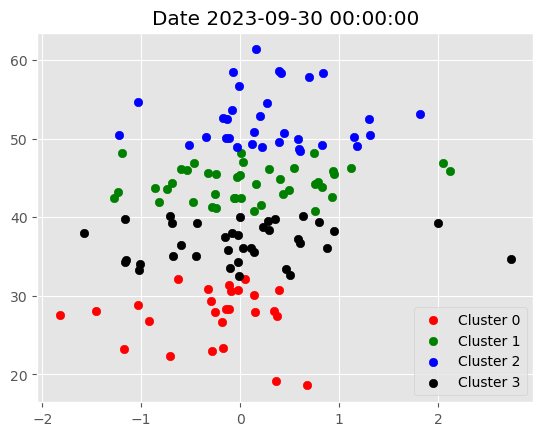

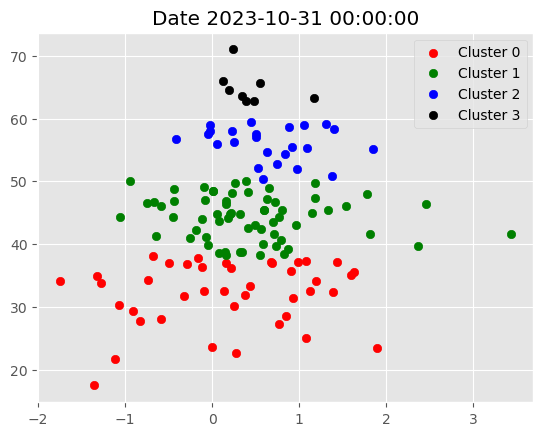

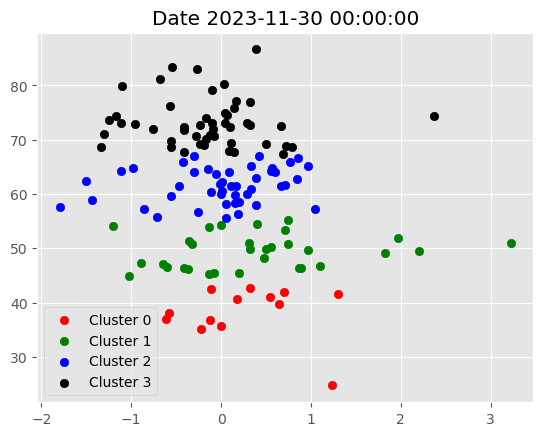

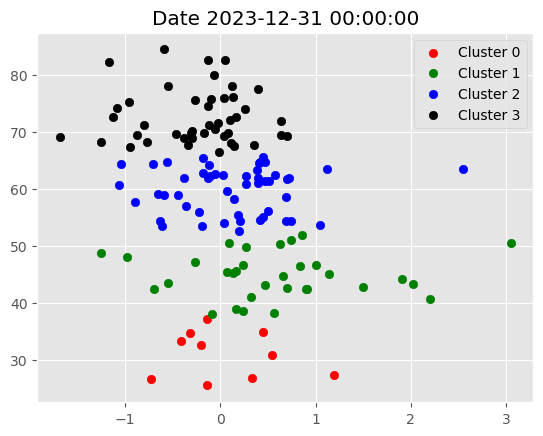

In [14]:
#We graph the for the diferent months
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g= data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## For each month select assets based on the cluster and form a portafolio based on Efficient Frontier max sharpe ratio optimization.
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.
* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month -thus I would select stocks corresponding to cluster 3.

In [15]:
#This will select stocks on the 3rd cluster
filtered_df = data[data['cluster']== 3].copy()

#Resetig the index
filtered_df = filtered_df.reset_index(level=1)

#use the index to add a day to it
filtered_df.index = filtered_df.index+pd.DateOffset(1)

#We set again the index to be the date and the ticker
filtered_df =filtered_df.reset_index().set_index(['date','ticker'])

#We build a list of the dates on the index of all the stocks of that month
dates = filtered_df.index.get_level_values('date').unique().tolist()

#A empty dictionary
fixed_dates = {}

#loop to gather all stocks and fill them on the empty dictionary
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-01-01': ['BA',
  'CAT',
  'CVX',
  'DE',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PXD',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'VLO'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMD',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMAT',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT', 'CL', 'COP', 'F', 'INTC', 'NEE', 'REGN', 'STZ', 'WYNN'],
 '2018-05-01': ['CMG',
  'COST',
  'CVS',
  'CVX',
  'EOG',
  'HAL',
  'MCD',
  'MCK',
  'OXY',
  'PXD',
  'ULTA',
  'UPS',
  'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'AVGO',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'MSFT',
  'NEE',
  'NFLX'

### Define the portafolio optimization funtion
* We will define a function which optimizes portfolio weights using ``PyPortfolioOpt`` package and ``EfficientFrontier`` optimizer to maximize the sharpe ratio.
* To optimize the wheights of a given portfolio we would need to supply last 1 year prices function.
* Apply single stock weight bounds constraint for diversification **(minimum half of the equal weight and maximum 10% of portfolio).**

In [16]:
#We will define the optimization weight function
def optimize_weights(prices, lower_bound = 0):
    #We need to calculate the expected returns 
    returns = expected_returns.mean_historical_return(prices = prices,
                                                      frequency = 252)
    #Calculate the covariance with the risk models
    cov = risk_models.sample_cov(prices = prices,
                                 frequency = 252)
    
    #We need to initialize the efficient frontier
    ef = EfficientFrontier(expected_returns = returns,
                          cov_matrix = cov,
                          weight_bounds = (lower_bound,.1),
                          solver= 'SCS')
    
    #Calculate the weights with the max_sharpe method
    weights = ef.max_sharpe()
    
    return ef.clean_weights()
    
    

### We will download fresh data for the stocks that are intresting

In [17]:
#This builds a list with the stocks
stocks = data.index.get_level_values('ticker').unique().tolist()

#Downloading the new data
new_df = yf.download(tickers = stocks,
                    start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months = 12),
                    end = data.index.get_level_values('date').unique()[-1])

new_df


[*********************100%%**********************]  155 of 155 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-01-03  44.741230   27.023703   45.883419   34.462334  104.547813   
2017-01-04  45.127762   26.993456   46.530380   34.735924  104.799164   
2017-01-05  44.345032   27.130728   46.883270   35.035980  103.228165   
2017-01-06  44.654255   27.433193   46.897984   35.989105  104.404190   
2017-01-09  45.494976   27.684467   47.206760   35.953808  103.237144   
...               ...         ...         ...         ...         ...   
2023-12-01  13.020000  191.240005  143.410004  104.879997  338.059998   
2023-12-04  13.350000  189.429993  144.149994  105.190002  336.429993   
2023-12-05  13.130000  193.419998  144.570007  104.349998  335.829987   
2023-12-06  13.480000  192.320007  146.380005  104.940002  335.410004   
2023-12-07  13.910000  194.270004  148.000000  104.080002  335.122986   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-03  103.480003   89.861206   76.180000  54.365154   29.419777  ...   
2017-01-04  104.139999   90.000137   77.519997  55.074768   29.696104  ...   
2017-01-05  105.910004   89.461823   76.930000  54.765865   29.567154  ...   
2017-01-06  108.300003   89.522591   79.300003  55.776039   29.511898  ...   
2017-01-09  108.570000   88.966942   79.589996  55.417057   30.193501  ...   
...                ...         ...         ...        ...         ...  ...   
2023-12-01  612.469971  232.940002  224.929993  65.970001  151.589996  ...   
2023-12-04  604.559998  232.580002  221.309998  66.000000  148.270004  ...   
2023-12-05  602.219971  231.559998  220.449997  65.900002  146.149994  ...   
2023-12-06  595.700012  232.350006  219.550003  65.370003  144.699997  ...   
2023-12-07  608.780029  229.990005  223.839996  65.400002  148.389999  ...   

              Volume                                                  \
                   V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2017-01-03  13785200  4425000  1761900  22891700   4942700   4479000   
2017-01-04   8033100  7431000  1667700  18316100   4125500   3653200   
2017-01-05   7805100  6450600  2354700  13840600   7401400   3638300   
2017-01-06   8898300  3771700  1669800  15615000   3949700   3274300   
2017-01-09   7305300  5132600  4522500  14097200   3293000   3909600   
...              ...      ...      ...       ...       ...       ...   
2023-12-01   3939400  2514800  1135000  20758400  12345400  11465100   
2023-12-04   5247500  2960000  1469500  22109200   9655400   3844000   
2023-12-05   4199100  3128600  1113200  23003300   8932200   3087600   
2023-12-06   3874000  3454000  1137600  20218500  14124800   3429100   
2023-12-07   2646782  2654251   776607  12001602  26296737   3566144   

                                                   
                 WFC       WMT     WYNN       XOM  
Date                                               
2017-01-03  22063800  10473200  2703500  10360600  
2017-01-04  15036100   7918000  2598800   9434200  
2017-01-05  18831600   7099200  2507500  14443200  
2017-01-06  18715900   9491100  1858400  16518100  
2017-01-09  21794100   8685200  2776200  13762300  
...              ...       ...      ...       ...  
2023-12-01  18114700  13085300  2046100  17843200  
2023-12-04  13424000   8294400  1997800  21523900  
2023-12-05  14531700   7294600  2366600  22250300  
2023-12-06  18923800   8815800  2340000  31154800  
2023-12-07  16323441   7408511  1620794  27145763  

[1745 rows x 930 columns]

#### Next steps:
* Calculate daily returns for each stock which could land up in a portfolio.
* The loop over each month start, select the stocks for the month and calculate their weights for the next month.
* If the maximum sharpe retio optimization fails for a given month, apply equally- weighted weights.
* Calculated each day portfolio return.

In [19]:
#We will create the returns dataframe
returns_dataframe = np.log(new_df['Adj Close']).diff()

#We will create a portfolio df
portfolio_df = pd.DataFrame()

#And a loop to start filling the last DF
for start_date in fixed_dates.keys():
    
    try:
        
        #We are investing each month and then we are rebalancing
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        #Get the colmns of the month
        cols= fixed_dates[start_date]
        #We need to create a optimization DF
        optimization_start_date= (pd.to_datetime(start_date)-pd.DateOffset(months= 12)).strftime('%Y-%m-%d')\
        
        optimization_end_date= (pd.to_datetime(start_date)-pd.DateOffset(days= 1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        #checks status of the calculation of the weights
        success = False
        
        try:
            #Sets the lower bound and formula of weigths
            weights = optimize_weights(prices= optimization_df,
                                       lower_bound = round(1/(len(optimization_df.columns)*2),3))
            #creates the df
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            #checks status of the calculation of the weights
            success=True
        
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Contionuing with Equal-Weigths')
        
        if success == False: 
            weigths = pd.DataFrame([1/len(optimization_df.columns) for i in range (len(optimization_df.columns))],
                                          index= optimization_df.columns.tolist(),
                                          columns = pd.Series(0)).T
            
        #selects the Df
        temp_df = returns_dataframe[start_date:end_date]
        
        #Work in order to show the final view of return and weigth
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop =True),
               left_index =True,
               right_index =True)\
        .reset_index().set_index(['Date','index']).unstack().stack()
        
        #fix the names
        temp_df.index.names = ['date','ticker']
        
        #Creates the weighted column
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        
        #Strategy return sums the weighted wins 
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        
        #Creation of the portfolio Df
        portfolio_df = pd.concat([portfolio_df, temp_df],axis = 0)
        
    
    except Exception as e:
            print(e)
                                       
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Contionuing with Equal-Weigths
Max Sharpe Optimization failed for 2020-03-01, Contionuing with Equal-Weigths
Max Sharpe Optimization failed for 2020-04-01, Contionuing with Equal-Weigths
Max Sharpe Optimization failed for 2021-02-01, Contionuing with Equal-Weigths
Max Sharpe Optimization failed for 2022-05-01, Contionuing with Equal-Weigths
Max Sharpe Optimization failed for 2022-09-01, Contionuing with Equal-Weigths
Max Sharpe Optimization failed for 2022-10-01, Contionuing with Equal-Weigths
Max Sharpe Optimization failed for 2023-02-01, Contionuing with Equal-Weigths
Max Sharpe Optimization failed for 2023-11-01, Contionuing with Equal-Weigths
'return'


,Strategy Return
date,
2018-01-02,0.003227
2018-01-03,0.007547
2018-01-04,0.003046
2018-01-05,0.005074
2018-01-08,0.004212
...,...
2023-12-01,0.012954
2023-12-04,-0.007140
2023-12-05,-0.000273


In [36]:
#We need to get the stocks for last month
temp_df

,
date,ticker


In [58]:
optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]



# We need to calculate the weights now
weights = optimize_weights(prices= optimization_df,
                           lower_bound = round(1/(len(optimization_df.columns)*2),3))

#we creat a Panda DF with the weights of our portfolio
weights = pd.DataFrame(weights, index=pd.Series(0))

weights

,AAL,ABBV,ABT,ACN,AMT,BA,BAC,BLK,C,CCL,...,RCL,SCHW,SHW,T,TGT,TMUS,UNP,USB,VZ,WFC
0,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.07284,...,0.1,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011


<Axes: xlabel='date'>

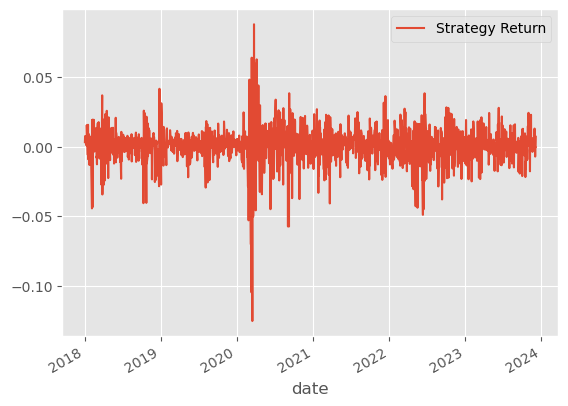

In [21]:
# We will plot the strategy
portfolio_df.plot()

## 8) Visualize portfolio returns and compare the SP500 returns.

In [22]:
#We need to download the return of the SP500
spy = yf.download(tickers = 'spy',
                 start= '2015-01-01',
                 end = dt.date.today())

#We create a new object containing the close price for each day
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'},axis=1)


#We will use the portfolio return to merge the Spy close with the portfolio
portfolio_df = portfolio_df.merge(spy_ret,
                                 left_index = True,
                                 right_index= True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-01-02,0.003227,0.007132
2018-01-03,0.007547,0.006305
2018-01-04,0.003046,0.004206
2018-01-05,0.005074,0.006642
2018-01-08,0.004212,0.001827
...,...,...
2023-11-30,0.008349,0.003930
2023-12-01,0.012954,0.005898
2023-12-04,-0.007140,-0.005263
2023-12-05,-0.000273,-0.000197


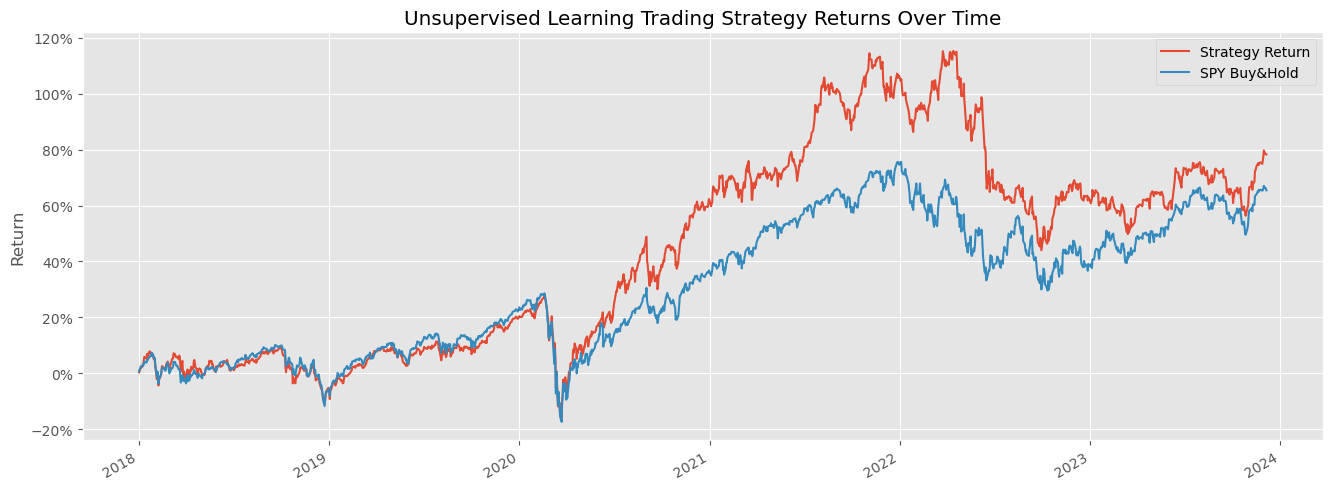

In [24]:
#Calculate the cumulative return for Sp500 and our strategy
plt.style.use('ggplot')

#Calculate the portfolio cumulative return
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

# to give information up until today and plot it
portfolio_cumulative_return[:dt.date.today().strftime('%Y-%m-%d')].plot(figsize = (16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

#fix the axis to give the data in % 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [62]:
#to visualize the complete list of stocks to buy this month and the weights to each
weights.stack()

0  AAL     0.01100
   ABBV    0.01100
   ABT     0.01100
   ACN     0.01100
   AMT     0.01100
   BA      0.01100
   BAC     0.01100
   BLK     0.01100
   C       0.01100
   CCL     0.07284
   CMG     0.10000
   COST    0.02443
   CRM     0.10000
   CSX     0.01100
   CVS     0.01100
   DAL     0.01100
   DG      0.01100
   EA      0.01100
   EXPE    0.01100
   FDX     0.09573
   FI      0.01100
   FIS     0.01100
   GM      0.01100
   HD      0.01100
   HON     0.01100
   IBM     0.01100
   JPM     0.01100
   KO      0.01100
   LULU    0.01100
   MCD     0.01100
   MMM     0.01100
   NKE     0.01100
   NOW     0.10000
   QCOM    0.01100
   RCL     0.10000
   SCHW    0.01100
   SHW     0.01100
   T       0.01100
   TGT     0.01100
   TMUS    0.01100
   UNP     0.01100
   USB     0.01100
   VZ      0.01100
   WFC     0.01100
dtype: float64